# Text classification with an RNN

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [27]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.savefig()
  plt.savefig('acc.png', dpi=200) 

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I finally watched these episodes in 2008 and I had to continually go back and verify when they were actually produced. They are absolutely scary in that they made spot on fun of what would be the future. Either Parker and Stone lived in Texas and witnessed the idiocy of Gov Bush or they are those weird, eerie people that pay attention to things. Boo, scary! Bush's frat bros invading the White House dressed as Arabs wielding rifles? Bush 'accidentally' executing someone? (No, wait. He did sort of do that as gov.) This may have seemed a failure as a sitcom at the time, but must now be considered as brilliant, if spooky, prescience."
 b'Up until the last few minutes of the movie, I would have given the movie a score of 7 or 8 stars. However, the ending is so terrible and "Hollywoodized" that it completely undermines the first 80% of the movie.<br /><br />The plot revolves around a submarine and the possibility that they received an order to fire their nuclear missiles. The Capt

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 397, 284, ...,   0,   0,   0],
       [ 58, 351,   2, ...,   0,   0,   0],
       [ 11,   1,   1, ...,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I finally watched these episodes in 2008 and I had to continually go back and verify when they were actually produced. They are absolutely scary in that they made spot on fun of what would be the future. Either Parker and Stone lived in Texas and witnessed the idiocy of Gov Bush or they are those weird, eerie people that pay attention to things. Boo, scary! Bush's frat bros invading the White House dressed as Arabs wielding rifles? Bush 'accidentally' executing someone? (No, wait. He did sort of do that as gov.) This may have seemed a failure as a sitcom at the time, but must now be considered as brilliant, if spooky, prescience."
Round-trip:  i finally watched these episodes in [UNK] and i had to [UNK] go back and [UNK] when they were actually [UNK] they are absolutely scary in that they made [UNK] on fun of what would be the future either [UNK] and [UNK] [UNK] in [UNK] and [UNK] the [UNK] of [UNK] [UNK] or they are those weird [UNK] people that [UNK] attention to things 

## Train the model

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 103s 185ms/step - loss: 0.6783 - accuracy: 0.5210 - val_loss: 0.4460 - val_accuracy: 0.8146
Epoch 2/20
391/391 [==============================] - 66s 168ms/step - loss: 0.4005 - accuracy: 0.8241 - val_loss: 0.3400 - val_accuracy: 0.8568
Epoch 3/20
391/391 [==============================] - 65s 167ms/step - loss: 0.3418 - accuracy: 0.8554 - val_loss: 0.3385 - val_accuracy: 0.8495
Epoch 4/20
391/391 [==============================] - 66s 169ms/step - loss: 0.3206 - accuracy: 0.8654 - val_loss: 0.3274 - val_accuracy: 0.8583
Epoch 5/20
391/391 [==============================] - 66s 168ms/step - loss: 0.3084 - accuracy: 0.8695 - val_loss: 0.3283 - val_accuracy: 0.8474
Epoch 6/20
391/391 [==============================] - 65s 166ms/step - loss: 0.3017 - accuracy: 0.8727 - val_loss: 0.3199 - val_accuracy: 0.8620
Epoch 7/20
391/391 [==============================] - 65s 167ms/step - loss: 0.2977 - accuracy: 0.8751 - val_loss: 0.3208 - val_a

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

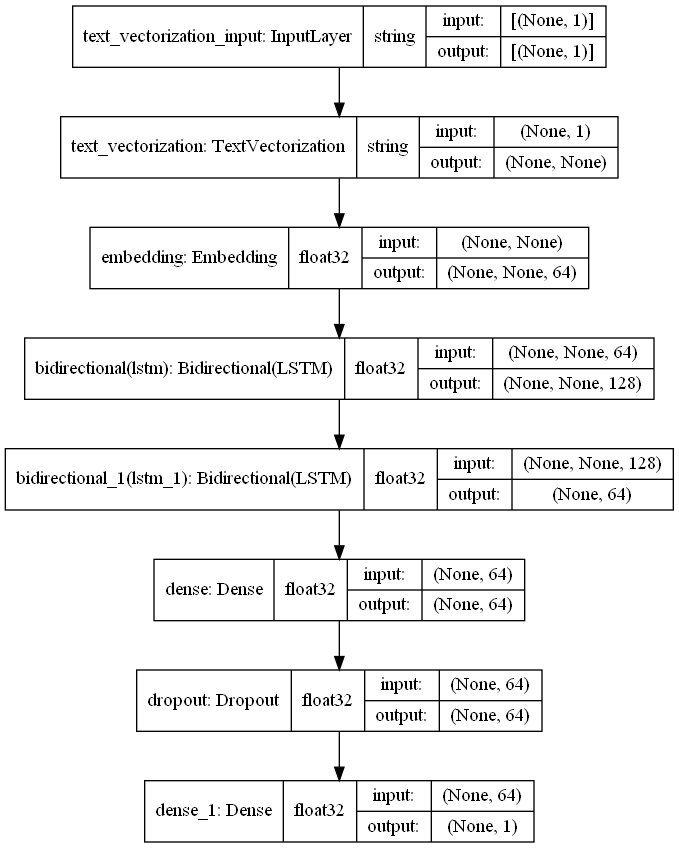

In [16]:
import keras
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [28]:
!pip install -q pyyaml h5py

In [23]:
!mkdir saved_model

In [24]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [37]:
# my_model directory
!ls saved_model

my_model


In [39]:
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

assets	saved_model.pb	variables


In [2]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()

In [5]:
open ("text_classification_v2.tflite" , "wb").write(tfmodel)

In [3]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = new_model.predict(np.array([sample_text]))
print(predictions)

[[-2.0183127]]


In [14]:
test_loss, test_acc = new_model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 29s 64ms/step - loss: 0.3289 - accuracy: 0.8461
Test Loss: 0.3289009630680084
Test Accuracy: 0.8461199998855591


In [17]:
test_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [19]:
X_test = list(map(lambda x: x[0], test_dataset))
y_test = list(map(lambda x: x[1], test_dataset))

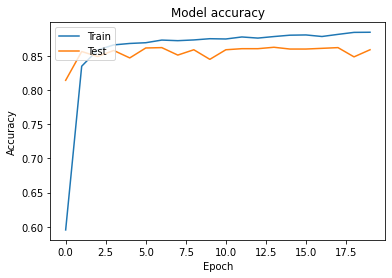

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
fig, ax = plt.subplots(1,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


fig.savefig('model1_train_test_accuracy.jpeg',dpi=93)

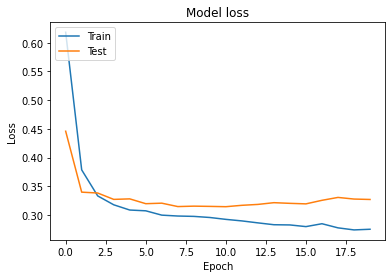

In [32]:
# Plot training & validation loss values
fig, ax = plt.subplots(1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('model1_train_test_los.jpeg',dpi=93)